# Text Classification in Cross-Validation using Long Short-Term Memory

## Import Libraries

In [57]:
import re
import time
import torch
import random
import numpy as np
import unicodedata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from lime import lime_text
from torch import nn, optim
from sklearn import metrics
from string import punctuation
from sklearn import preprocessing
from nltk.corpus import stopwords, wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

## Set Hyparameters

### Dataset Language Setting

In [58]:
language="english"

language_w="../input/fasttext-aligned-word-vectors/wiki.en.align.vec"

### Model Parameters

In [59]:
batch_size = 128
dropout_pc = 0.5
n_epochs = 100
patience=5
hidden_dim=50
lr = 1e-3
num_layers=1
bidirectional=True

nfold=10

### Dataset Parameters

In [60]:
path_db="../input/indian-parliament/rajyasabha_questions_and_answers.xlsx"
df = pd.read_excel(path_db, sheet_name="rajyasabha_questions_and_answer")

text="question_description"
review="ministry"

n_top_class=70

## Enable GPU

In [61]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 2019
#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

## Load Dataset

In [62]:
top_class=df.groupby(review).count()[[text]]
top_class=top_class.sort_values(by=[text], ascending=False).head(n_top_class)
top_class=top_class.apply(list).reset_index()
top_class = [d for d in top_class[review]]
print(top_class)

df=df.loc[df[review].isin(top_class)]
print(f'Found {len(df)} texts.')
print(f'{df[review].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df[review])]

df = df[df[text].str.split().str.len().gt(5)]

print(f'{df[text].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df[text])]

le = preprocessing.LabelEncoder()
le.fit(df[review])
df[review]=le.transform(df[review])
classes = [int(c) for c in df[review].values]
documents = [d for d in df[text]]

output_dim = len(np.unique(classes))

['HOME AFFAIRS', 'FINANCE', 'HEALTH AND FAMILY WELFARE', 'RAILWAYS', 'HUMAN RESOURCE DEVELOPMENT', 'AGRICULTURE AND FARMERS WELFARE', 'ENVIRONMENT, FOREST AND CLIMATE CHANGE', 'PETROLEUM AND NATURAL GAS', 'CIVIL AVIATION', 'CONSUMER AFFAIRS, FOOD AND PUBLIC DISTRIBUTION', 'COMMUNICATION, ELECTRONICS AND INFORMATION TECHNOLOGY', 'LABOUR AND EMPLOYMENT', 'DEFENCE', 'EXTERNAL AFFAIRS', 'POWER', 'ROAD TRANSPORT & HIGH WAYS', 'WATER RESOURCES, RIVER DEVELOPMENT AND GANGA REJUVENATION', 'COMMERCE AND INDUSTRY', 'RURAL DEVELOPMENT', 'WOMEN AND CHILD DEVELOPMENT', 'COAL', 'SKILL DEVELOPMENT, ENTERPRENEURSHIP, YOUTH AFFAIRS AND SPORTS', 'LAW & JUSTICE', 'CHEMICALS AND FERTILIZERS', 'SOCIAL JUSTICE AND EMPOWERMENT', 'URBAN DEVELOPMENT', 'COMMERCE AND INDUSTRY  ', 'INFORMATION AND BROADCASTING', 'TOURISM', 'CULTURE', 'PERSONNEL,PUBLIC GRIEVANCES AND PENSIONS', 'HOUSING AND URBAN POVERTY ALLEVIATION', 'DRINKING WATER AND SANITATION', 'NEW AND RENEWABLE ENERGY', 'TEXTILES', 'PLANNING', 'ROAD TRANSP

## Class Distribution Diagram

Number of Classes found:  69


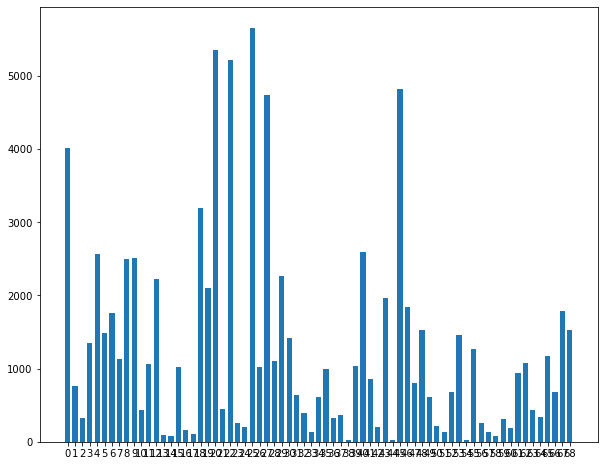

In [63]:
y = np.bincount(classes)
x = np.arange(len(y))
print("Number of Classes found: ", len(y))
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x, y,width=0.7)
ax.set_xticks(x)
ax.set_aspect('auto')
plt.show()


## Define Preprocessor

In [64]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    #text = re.sub(r'[^\w\s]'," ", text)
    text=re.sub('\d+',' ',str(text))
    text=re.sub('[ﾫﾻ]','',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower().strip()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text

def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

stop=set(stopwords.words(language))

def tokenizer(text):
    stop=set(stopwords.words(language))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    filtered_sentence = [w for w in filtered_sentence if len(w)>3]
    return filtered_sentence
    
def split_words_documents(documents):
    tokenized = documents = [tokenizer(strip_accents(preprocessor(document))) 
                              for document in documents]
    all_text = []
    for tokens in tokenized:
        for t in tokens:
            all_text.append(t)
    return tokenized, set(all_text)

In [65]:
documents, vocab = split_words_documents(documents)

## Preprocessed Dataset Statistics

In [66]:
print("Max sequence length: ", np.max([len(x) for x in documents]))
print("Average sequence length: ",np.mean([len(x) for x in documents]))
quant=np.quantile([len(x) for x in documents],.75)
hidden_dim=int(quant)
print("Quantile sequence length: ",quant)

Max sequence length:  1219
Average sequence length:  32.85072297813103
Quantile sequence length:  40.0


## Vocabulary Build

In [67]:
#vocaboli=set(line.strip() for line in open('../input/prova2/prova.txt'))

vocaboli=set([word for word in wn.words()])
vocaboli_more=vocaboli.union(vocab)
print("Aggiunte ",len(vocaboli_more)-len(vocaboli),"/",len(vocab)," parole")

Aggiunte  27428 / 41354  parole


In [68]:
def create_dictionaries(words):
    word_to_int_dict = {w:i+1 for i,w in enumerate(words)}
    int_to_word_dict = {i:w for w,i in word_to_int_dict.items()}
    return word_to_int_dict, int_to_word_dict
word_to_int_dict, int_to_word_dict = create_dictionaries(vocaboli)

## Define Padding

In [69]:
def pad_text(tokenized_documents,seq_length):
    documents = []
    length=[]
    for document in tokenized_documents:
        if len(document) >= seq_length:
            documents.append(document[:seq_length])
            length.append(seq_length)
        else:
            length.append(len(document))
            documents.append(document+['']*(seq_length-len(document)))
    return np.array(documents),np.array(length)


In [70]:
int_to_word_dict[0]=''
word_to_int_dict['']=0

## Pretrained Vector Loader

In [71]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.double)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [72]:
# Load pretrained vectors
print("Tokenizing...\n")
embeddings = load_pretrained_vectors(word_to_int_dict, language_w)
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


2519370it [01:40, 24958.21it/s]


There are 70542 / 147307 pretrained vectors found.


## Utility Functions

In [73]:
def sort_batch(X,lengths,y):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X,lengths, y 

### DataLoader Function

In [74]:
def create_data_loader(train_c,train_len, valid_c, valid_len, train_l,valid_l,batch_size):
    x_train = torch.tensor(train_c, dtype=torch.long,device=DEVICE)
    x_train_len = torch.tensor(train_len, dtype=torch.long,device=DEVICE)
    y_train = torch.tensor(train_l, dtype=torch.long, device=DEVICE)
    x_cv = torch.tensor(valid_c, dtype=torch.long, device=DEVICE)
    x_cv_len = torch.tensor(valid_len, dtype=torch.long, device=DEVICE)
    y_cv = torch.tensor(valid_l, dtype=torch.long, device=DEVICE)
    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train,x_train_len, y_train)
    valid = torch.utils.data.TensorDataset(x_cv,x_cv_len, y_cv)
    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader
    

### Plot Function

In [75]:
def plot_graph(train_loss, valid_loss):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    #plt.ylim(0, 0.5) # consistent scale
    #plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### EarlyStopping Function

In [76]:
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Define Model

In [77]:
class ClassificationRNN(nn.Module):
    
    def __init__(self, 
                 pretrained_embedding=None,
                freeze_embedding=False,
                 n_vocab=None,
                 hidden_dim=100,
                 output_dim=13,
                 dropout = 0.8,
                 pad_idx=0.0,
                 num_layers=2,
                bidirectional=True):
        super().__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.n_vocab, self.n_embed = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        
        
         
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(self.n_embed, 
                           hidden_dim,
                           num_layers=num_layers,
                          bidirectional=bidirectional,
                          dropout=0 if num_layers < 2 else dropout,
                          batch_first=True)
        self.fc1 = nn.Linear(hidden_dim * 4 if bidirectional else hidden_dim*2,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        

        
        
    def forward(self, text, text_length):
        h_embedding = self.dropout(self.embedding(text))
        #packed = torch.nn.utils.rnn.pack_padded_sequence(h_embedding, text_length,batch_first=True, enforce_sorted=False)
        h_lstm, (h,c) = self.rnn(h_embedding)
        #h_lstm, output_lengths = nn.utils.rnn.pad_packed_sequence(h_lstm,batch_first=True)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        
        out=self.fc1(conc)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

## Evaluate Function

In [78]:
def evaluate(model, data_loader, criterion):
    model.eval()
    val_accuracy = []
    val_loss = []
    with torch.no_grad():
        for i, (x_batch,len_batch, y_batch) in enumerate(data_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            logits= model(x_batch,len_batch)
            loss = criterion(logits, y_batch)
            val_loss.append(loss.item())
            
            _, preds = torch.max(logits, 1)
            accuracy = (preds == y_batch).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

## Define Train Function

In [79]:
def train(model, optimizer,criterion, train_loader, val_loader=None, patience=7, epochs=10):
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)
    best_accuracy=0
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        t0_epoch = time.time()
        total_loss = 0
        ###################
        # train the model #
        ###################
        model.train()
        for i, (x_batch,len_batch, y_batch) in enumerate(train_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            y_pred= model(x_batch,len_batch)
            # calculate the loss
            loss = criterion(y_pred, y_batch)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        ######################    
        # validate the model #
        ###################### 
        valid_losses, val_accuracy = evaluate(model, val_loader,criterion)
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        time_elapsed = time.time() - t0_epoch
        print(f"{epoch :^7} | {train_loss:^12.6f} | {valid_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        
    print("\n")
    
    plot_graph(avg_train_losses, avg_valid_losses)
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model
    

## Define Predict Function

In [80]:
def pytorch_predict(model, test_loader):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    labels=[]
    with torch.no_grad():
        for (text,length, label) in test_loader: 
            #text,length, label=sort_batch(text,length, label)
            outputs = model(text,length)
            _, preds = torch.max(outputs, 1)
            for pred in preds:
                labels.append(pred.item())
    
    return labels

In [81]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## Cross-Validation Loop

train: (80168, 40) len: 80168 train_y: 80168
test: (8908, 40) len: 8908
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  406.849470  | 322.714109 |   38.74   |   17.73  
Validation loss decreased (inf --> 322.714109).  Saving model ...
   2    |  291.087251  | 257.158430 |   54.12   |   18.49  
Validation loss decreased (322.714109 --> 257.158430).  Saving model ...
   3    |  246.672617  | 227.668263 |   58.20   |   17.88  
Validation loss decreased (257.158430 --> 227.668263).  Saving model ...
   4    |  221.159536  | 211.631710 |   60.69   |   17.71  
Validation loss decreased (227.668263 --> 211.631710).  Saving model ...
   5    |  207.379098  | 208.117358 |   61.65   |   18.34  
Validation loss decreased (211.631710 --> 208.117358).  Saving model ...
   6    |  195.789355  | 203.431758 |   62.85   |   18.03  
Validation loss decreased (208.117358 --> 203.431758).  Saving model .

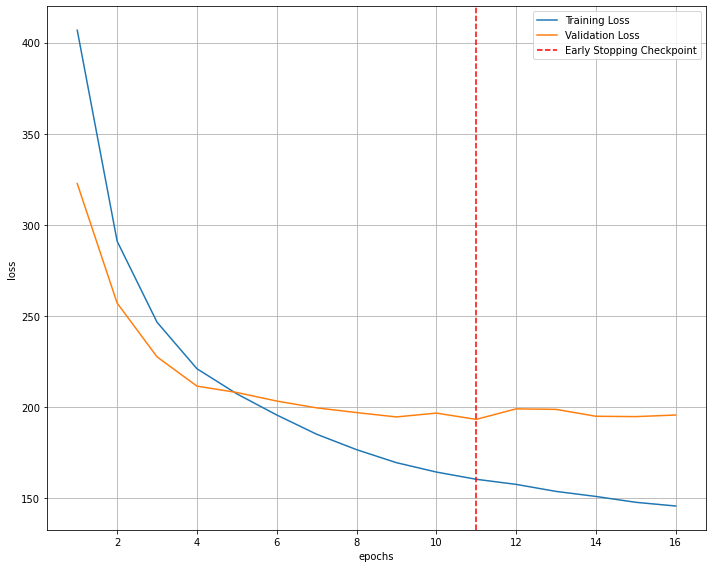

--------------- Fold:  1 ---------------------

              precision    recall  f1-score   support

           0       0.75      0.67      0.71       401
           1       0.77      0.80      0.79        76
           2       0.88      0.72      0.79        32
           3       0.75      0.53      0.62       134
           4       0.70      0.78      0.74       256
           5       0.81      0.91      0.86       149
           6       0.36      0.60      0.45       176
           7       0.00      0.00      0.00       113
           8       0.71      0.73      0.72       249
           9       0.76      0.73      0.74       251
          10       0.37      0.35      0.36        43
          11       0.71      0.60      0.65       106
          12       0.75      0.74      0.74       223
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00         8
          15       0.67      0.85      0.75       102
          16       0.00      0.00

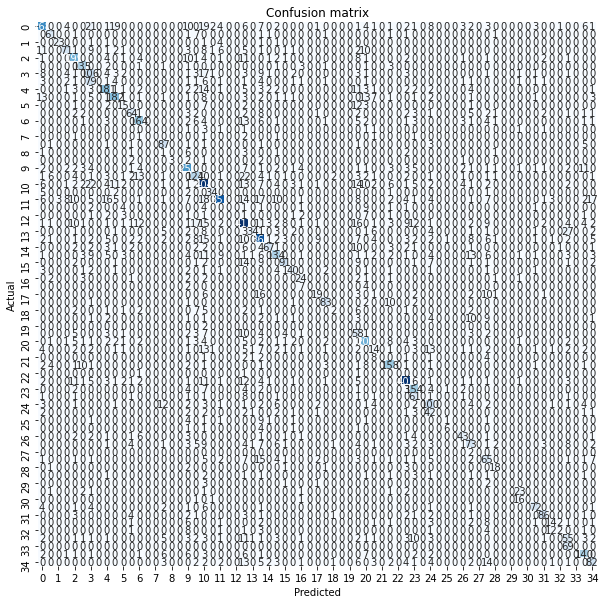


train: (80168, 40) len: 80168 train_y: 80168
test: (8908, 40) len: 8908
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  412.609296  | 327.578705 |   35.35   |   17.94  
Validation loss decreased (inf --> 327.578705).  Saving model ...
   2    |  299.064262  | 262.003984 |   53.29   |   17.83  
Validation loss decreased (327.578705 --> 262.003984).  Saving model ...
   3    |  253.439697  | 234.570469 |   57.59   |   18.19  
Validation loss decreased (262.003984 --> 234.570469).  Saving model ...
   4    |  231.385271  | 217.293900 |   60.98   |   18.31  
Validation loss decreased (234.570469 --> 217.293900).  Saving model ...
   5    |  213.871620  | 210.500756 |   62.33   |   17.85  
Validation loss decreased (217.293900 --> 210.500756).  Saving model ...
   6    |  200.499532  | 201.777999 |   63.48   |   18.16  
Validation loss decreased (210.500756 --> 201.777999).  Saving model 

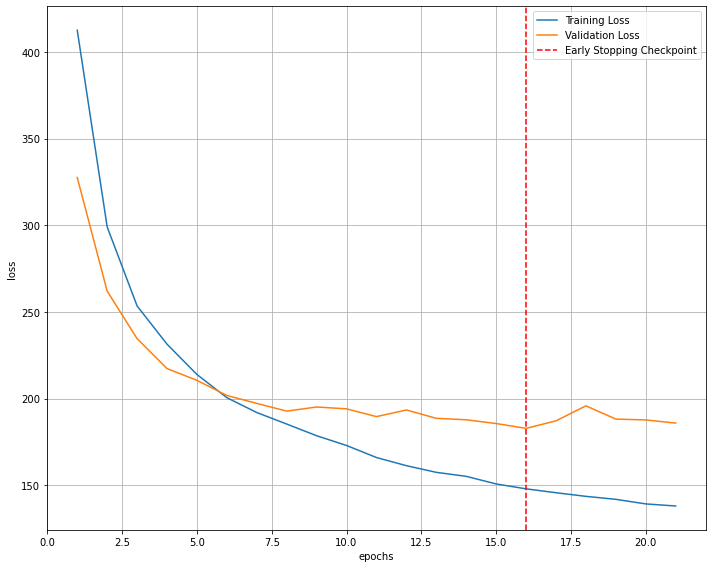

--------------- Fold:  2 ---------------------

              precision    recall  f1-score   support

           0       0.70      0.78      0.74       402
           1       0.81      0.91      0.86        76
           2       0.93      0.44      0.60        32
           3       0.77      0.56      0.65       134
           4       0.71      0.79      0.75       256
           5       0.83      0.93      0.88       149
           6       0.33      0.65      0.44       176
           7       0.00      0.00      0.00       113
           8       0.83      0.70      0.76       249
           9       0.74      0.75      0.74       251
          10       0.53      0.21      0.30        43
          11       0.75      0.72      0.74       107
          12       0.78      0.74      0.76       223
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00         8
          15       0.58      0.81      0.67       101
          16       0.43      0.19

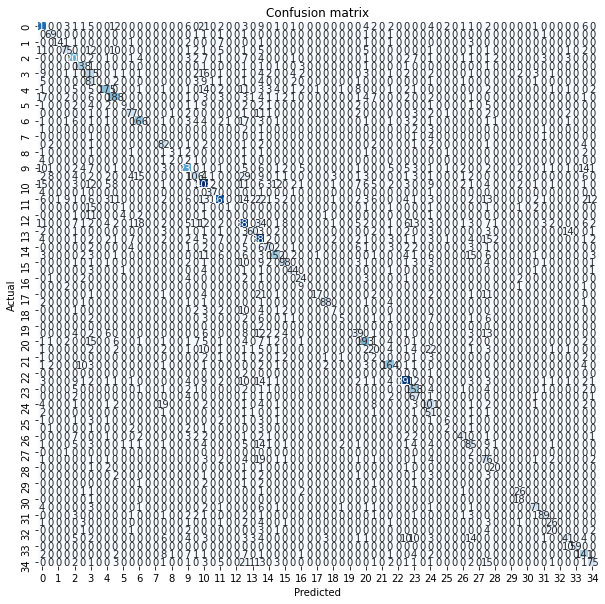


train: (80168, 40) len: 80168 train_y: 80168
test: (8908, 40) len: 8908
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  423.791544  | 329.461283 |   34.75   |   18.17  
Validation loss decreased (inf --> 329.461283).  Saving model ...
   2    |  317.009522  | 257.203054 |   53.79   |   18.18  
Validation loss decreased (329.461283 --> 257.203054).  Saving model ...
   3    |  268.398692  | 224.760104 |   59.91   |   18.26  
Validation loss decreased (257.203054 --> 224.760104).  Saving model ...
   4    |  241.679368  | 210.116295 |   62.60   |   17.88  
Validation loss decreased (224.760104 --> 210.116295).  Saving model ...
   5    |  227.594421  | 201.166550 |   63.91   |   17.62  
Validation loss decreased (210.116295 --> 201.166550).  Saving model ...
   6    |  218.052705  | 196.235561 |   64.31   |   18.34  
Validation loss decreased (201.166550 --> 196.235561).  Saving model 

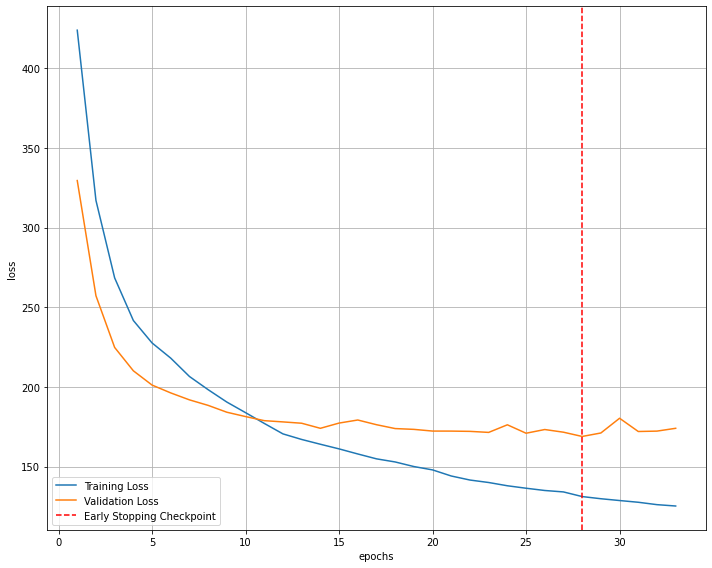

--------------- Fold:  3 ---------------------

              precision    recall  f1-score   support

           0       0.71      0.70      0.70       402
           1       0.81      0.89      0.85        76
           2       0.83      0.16      0.26        32
           3       0.81      0.58      0.68       134
           4       0.60      0.77      0.68       257
           5       0.80      0.87      0.83       150
           6       0.45      0.70      0.55       176
           7       0.00      0.00      0.00       113
           8       0.80      0.77      0.79       250
           9       0.74      0.80      0.77       251
          10       0.68      0.39      0.49        44
          11       0.89      0.94      0.92       106
          12       0.81      0.74      0.77       223
          13       0.40      0.20      0.27        10
          14       0.00      0.00      0.00         9
          15       0.68      0.83      0.75       102
          16       0.71      0.31

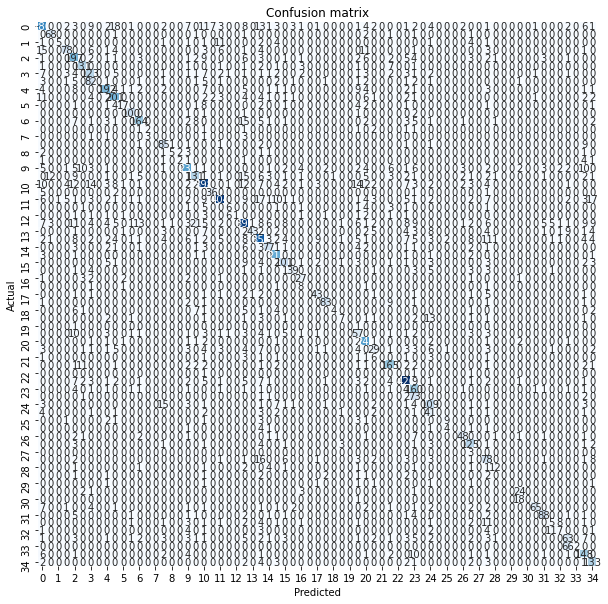


train: (80168, 40) len: 80168 train_y: 80168
test: (8908, 40) len: 8908
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  418.430274  | 328.752561 |   31.79   |   17.84  
Validation loss decreased (inf --> 328.752561).  Saving model ...
   2    |  321.492815  | 264.331198 |   49.99   |   17.92  
Validation loss decreased (328.752561 --> 264.331198).  Saving model ...
   3    |  271.768933  | 216.132059 |   60.60   |   18.44  
Validation loss decreased (264.331198 --> 216.132059).  Saving model ...
   4    |  242.185642  | 201.696086 |   62.05   |   17.78  
Validation loss decreased (216.132059 --> 201.696086).  Saving model ...
   5    |  225.981631  | 192.143954 |   63.92   |   17.92  
Validation loss decreased (201.696086 --> 192.143954).  Saving model ...
   6    |  215.666302  | 185.409898 |   64.75   |   18.16  
Validation loss decreased (192.143954 --> 185.409898).  Saving model 

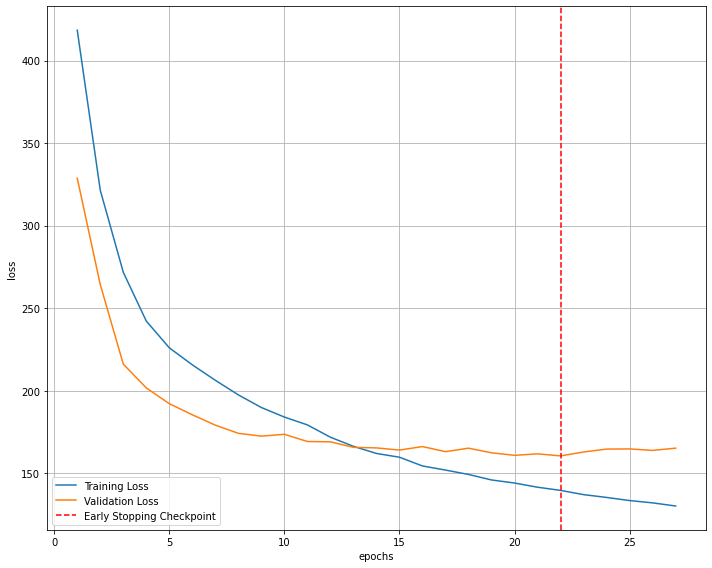

--------------- Fold:  4 ---------------------

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       402
           1       0.79      0.92      0.85        76
           2       1.00      0.69      0.81        32
           3       0.79      0.63      0.70       134
           4       0.81      0.75      0.78       257
           5       0.81      0.90      0.85       150
           6       0.41      0.61      0.49       176
           7       0.00      0.00      0.00       113
           8       0.61      0.72      0.66       250
           9       0.74      0.78      0.76       251
          10       0.47      0.39      0.42        44
          11       0.95      1.00      0.97       106
          12       0.85      0.74      0.79       223
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00         8
          15       0.77      0.76      0.77       102
          16       0.76      1.00

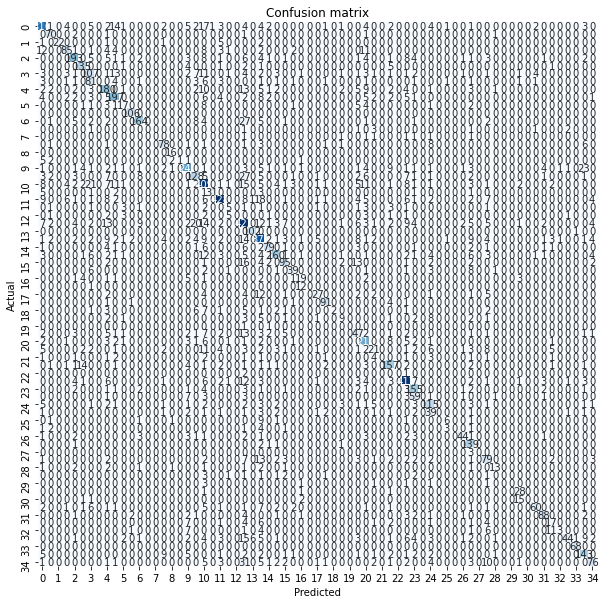


train: (80168, 40) len: 80168 train_y: 80168
test: (8908, 40) len: 8908
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  424.050371  | 323.890395 |   34.78   |   17.86  
Validation loss decreased (inf --> 323.890395).  Saving model ...
   2    |  309.355331  | 236.751290 |   53.21   |   17.84  
Validation loss decreased (323.890395 --> 236.751290).  Saving model ...
   3    |  257.398835  | 204.541129 |   61.13   |   18.50  
Validation loss decreased (236.751290 --> 204.541129).  Saving model ...
   4    |  231.439038  | 189.001170 |   62.85   |   17.76  
Validation loss decreased (204.541129 --> 189.001170).  Saving model ...
   5    |  214.527578  | 177.146538 |   64.84   |   18.05  
Validation loss decreased (189.001170 --> 177.146538).  Saving model ...
   6    |  201.088146  | 171.599241 |   66.74   |   18.89  
Validation loss decreased (177.146538 --> 171.599241).  Saving model 

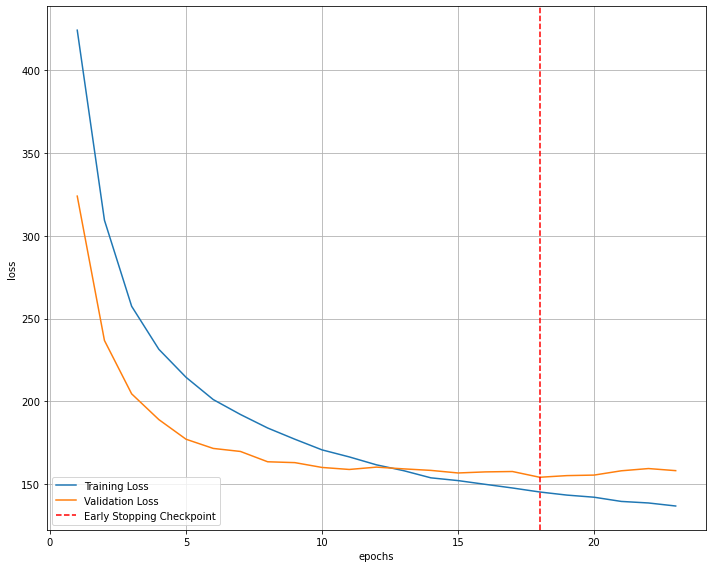

--------------- Fold:  5 ---------------------

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       402
           1       0.79      0.87      0.82        76
           2       1.00      1.00      1.00        33
           3       0.77      0.64      0.70       135
           4       0.65      0.83      0.73       257
           5       0.85      0.93      0.89       149
           6       0.43      0.76      0.55       175
           7       0.00      0.00      0.00       113
           8       0.79      0.70      0.74       249
           9       0.73      0.77      0.75       251
          10       0.81      0.39      0.52        44
          11       0.88      0.99      0.93       106
          12       0.78      0.73      0.76       223
          13       0.88      0.70      0.78        10
          14       0.00      0.00      0.00         8
          15       0.79      0.75      0.77       102
          16       0.65      1.00

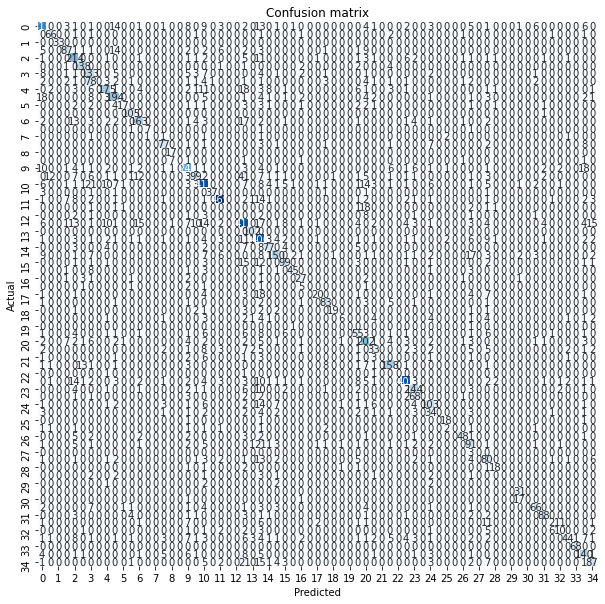


train: (80168, 40) len: 80168 train_y: 80168
test: (8908, 40) len: 8908
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  416.609209  | 309.333722 |   37.77   |   18.02  
Validation loss decreased (inf --> 309.333722).  Saving model ...
   2    |  305.402990  | 231.292807 |   57.03   |   18.06  
Validation loss decreased (309.333722 --> 231.292807).  Saving model ...
   3    |  258.942789  | 202.485882 |   61.55   |   17.96  
Validation loss decreased (231.292807 --> 202.485882).  Saving model ...
   4    |  232.758323  | 185.144729 |   64.51   |   18.21  
Validation loss decreased (202.485882 --> 185.144729).  Saving model ...
   5    |  216.565722  | 175.071209 |   66.94   |   17.93  
Validation loss decreased (185.144729 --> 175.071209).  Saving model ...
   6    |  206.293650  | 170.546168 |   67.41   |   18.27  
Validation loss decreased (175.071209 --> 170.546168).  Saving model 

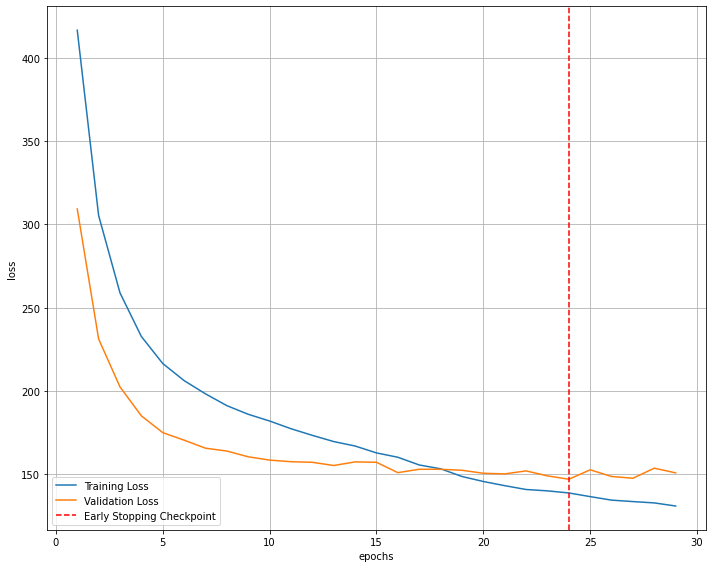

--------------- Fold:  6 ---------------------

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       402
           1       0.84      0.82      0.83        76
           2       1.00      0.94      0.97        33
           3       0.85      0.89      0.87       135
           4       0.76      0.76      0.76       257
           5       0.93      0.96      0.94       149
           6       0.43      0.70      0.53       175
           7       0.00      0.00      0.00       113
           8       0.77      0.71      0.74       249
           9       0.81      0.82      0.82       251
          10       0.58      0.50      0.54        44
          11       0.87      0.86      0.86       106
          12       0.79      0.76      0.78       223
          13       0.50      0.10      0.17        10
          14       0.00      0.00      0.00         8
          15       0.85      0.80      0.82       102
          16       0.89      1.00

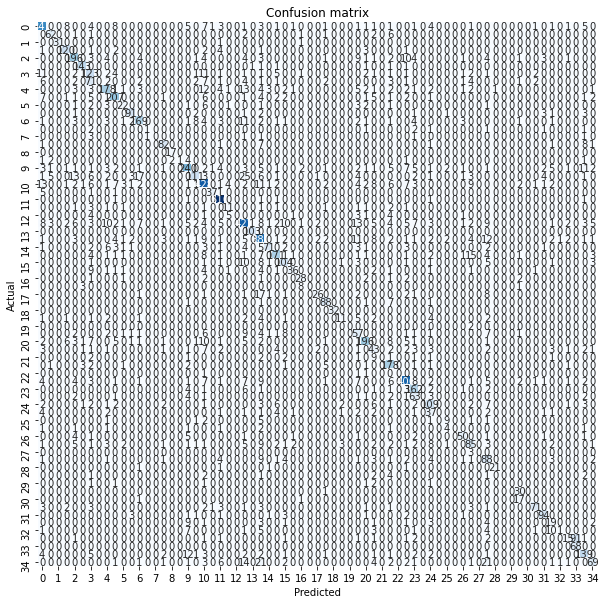


train: (80169, 40) len: 80169 train_y: 80169
test: (8907, 40) len: 8907
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  420.043680  | 311.839999 |   35.64   |   17.79  
Validation loss decreased (inf --> 311.839999).  Saving model ...
   2    |  306.107002  | 230.755428 |   56.27   |   17.89  
Validation loss decreased (311.839999 --> 230.755428).  Saving model ...
   3    |  259.082324  | 199.422000 |   62.31   |   17.70  
Validation loss decreased (230.755428 --> 199.422000).  Saving model ...
   4    |  232.521466  | 184.242916 |   64.48   |   17.79  
Validation loss decreased (199.422000 --> 184.242916).  Saving model ...
   5    |  216.161585  | 175.376406 |   66.49   |   18.25  
Validation loss decreased (184.242916 --> 175.376406).  Saving model ...
   6    |  204.990064  | 166.033472 |   67.66   |   17.75  
Validation loss decreased (175.376406 --> 166.033472).  Saving model 

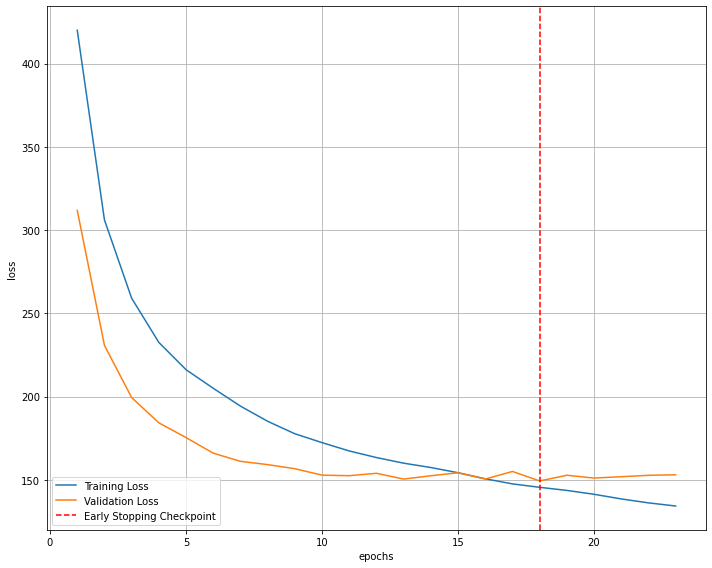

--------------- Fold:  7 ---------------------

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       402
           1       0.87      0.97      0.92        76
           2       1.00      1.00      1.00        32
           3       0.84      0.80      0.82       135
           4       0.80      0.74      0.77       257
           5       0.85      0.96      0.90       149
           6       0.41      0.69      0.51       175
           7       0.00      0.00      0.00       113
           8       0.78      0.73      0.76       249
           9       0.78      0.80      0.79       251
          10       0.63      0.61      0.62        44
          11       0.90      0.99      0.94       106
          12       0.76      0.74      0.75       223
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00         8
          15       0.81      0.89      0.85       102
          16       0.85      1.00

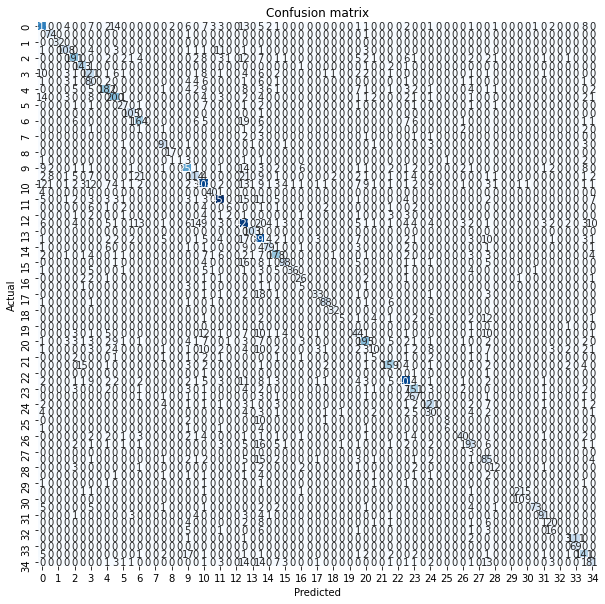


train: (80169, 40) len: 80169 train_y: 80169
test: (8907, 40) len: 8907
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  415.520838  | 304.614574 |   39.74   |   17.78  
Validation loss decreased (inf --> 304.614574).  Saving model ...
   2    |  300.475843  | 233.667471 |   56.29   |   18.24  
Validation loss decreased (304.614574 --> 233.667471).  Saving model ...
   3    |  251.755734  | 192.964199 |   62.66   |   17.95  
Validation loss decreased (233.667471 --> 192.964199).  Saving model ...
   4    |  222.045219  | 176.200552 |   65.65   |   17.67  
Validation loss decreased (192.964199 --> 176.200552).  Saving model ...
   5    |  204.940121  | 165.845775 |   67.75   |   18.26  
Validation loss decreased (176.200552 --> 165.845775).  Saving model ...
   6    |  193.578190  | 161.375736 |   68.39   |   18.03  
Validation loss decreased (165.845775 --> 161.375736).  Saving model 

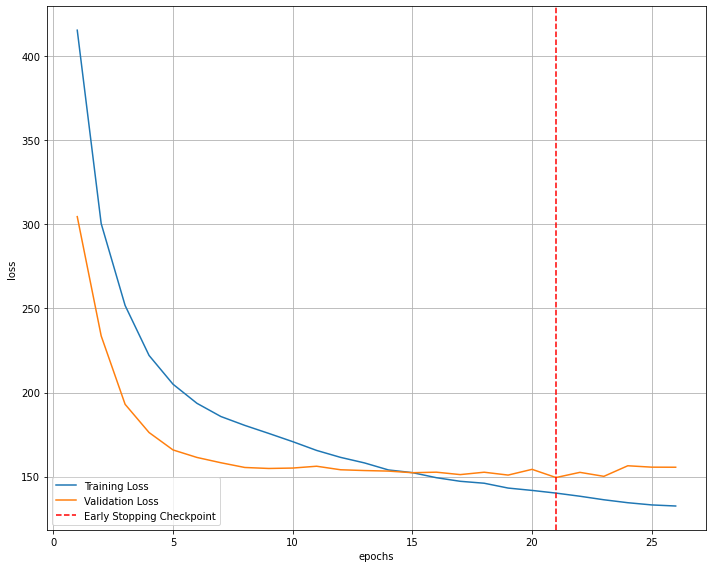

--------------- Fold:  8 ---------------------

              precision    recall  f1-score   support

           0       0.71      0.82      0.76       402
           1       0.91      0.91      0.91        76
           2       0.91      1.00      0.96        32
           3       0.80      0.96      0.87       135
           4       0.78      0.72      0.75       257
           5       0.90      0.91      0.91       149
           6       0.45      0.65      0.53       175
           7       0.00      0.00      0.00       113
           8       0.84      0.71      0.77       249
           9       0.71      0.66      0.68       251
          10       0.57      0.52      0.55        44
          11       0.91      0.67      0.77       106
          12       0.80      0.76      0.78       223
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00         8
          15       0.73      0.86      0.79       102
          16       0.74      1.00

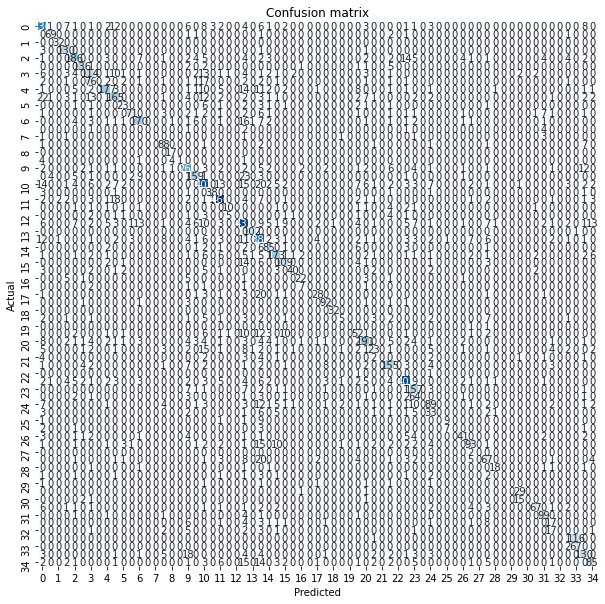


train: (80169, 40) len: 80169 train_y: 80169
test: (8907, 40) len: 8907
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  422.645457  | 312.669201 |   33.98   |   18.03  
Validation loss decreased (inf --> 312.669201).  Saving model ...
   2    |  323.510897  | 263.179475 |   46.43   |   17.98  
Validation loss decreased (312.669201 --> 263.179475).  Saving model ...
   3    |  279.284412  | 214.435855 |   58.60   |   18.38  
Validation loss decreased (263.179475 --> 214.435855).  Saving model ...
   4    |  248.341481  | 194.980918 |   63.31   |   17.97  
Validation loss decreased (214.435855 --> 194.980918).  Saving model ...
   5    |  230.400199  | 181.956206 |   64.96   |   17.90  
Validation loss decreased (194.980918 --> 181.956206).  Saving model ...
   6    |  216.393646  | 178.675147 |   65.66   |   18.53  
Validation loss decreased (181.956206 --> 178.675147).  Saving model 

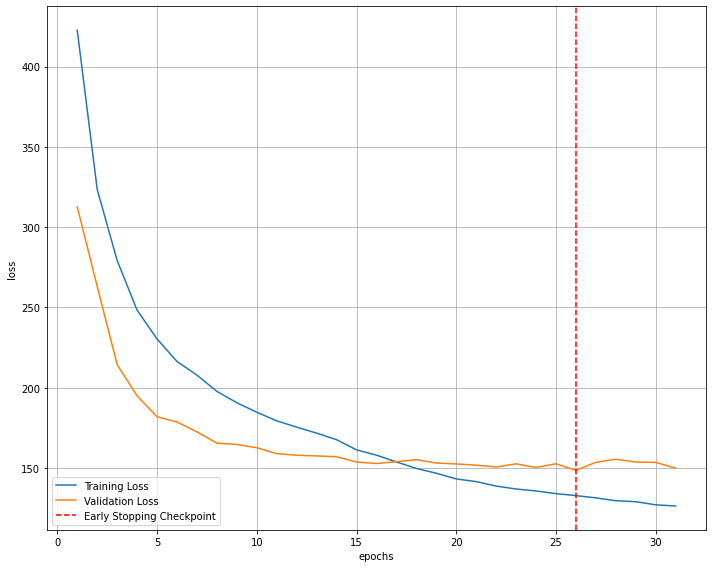

--------------- Fold:  9 ---------------------

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       402
           1       0.97      0.88      0.92        76
           2       0.97      1.00      0.98        32
           3       0.89      0.98      0.93       135
           4       0.75      0.78      0.77       257
           5       0.94      0.88      0.91       149
           6       0.44      0.77      0.56       175
           7       0.00      0.00      0.00       113
           8       0.62      0.86      0.73       249
           9       0.80      0.70      0.75       250
          10       0.46      0.41      0.43        44
          11       0.90      0.60      0.72       106
          12       0.80      0.75      0.77       224
          13       0.33      0.22      0.27         9
          14       0.00      0.00      0.00         8
          15       0.79      0.79      0.79       102
          16       0.77      1.00

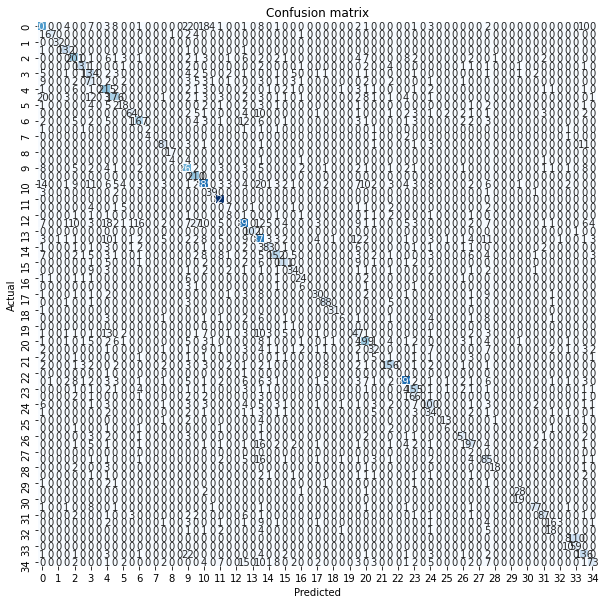


train: (80169, 40) len: 80169 train_y: 80169
test: (8907, 40) len: 8907
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  416.928264  | 312.476329 |   37.58   |   17.78  
Validation loss decreased (inf --> 312.476329).  Saving model ...
   2    |  314.703142  | 263.781094 |   48.82   |   18.16  
Validation loss decreased (312.476329 --> 263.781094).  Saving model ...
   3    |  278.956947  | 230.191414 |   58.82   |   17.69  
Validation loss decreased (263.781094 --> 230.191414).  Saving model ...
   4    |  251.662319  | 207.385246 |   62.58   |   17.68  
Validation loss decreased (230.191414 --> 207.385246).  Saving model ...
   5    |  232.383460  | 192.296396 |   64.55   |   18.19  
Validation loss decreased (207.385246 --> 192.296396).  Saving model ...
   6    |  217.121677  | 182.978039 |   66.42   |   17.76  
Validation loss decreased (192.296396 --> 182.978039).  Saving model 

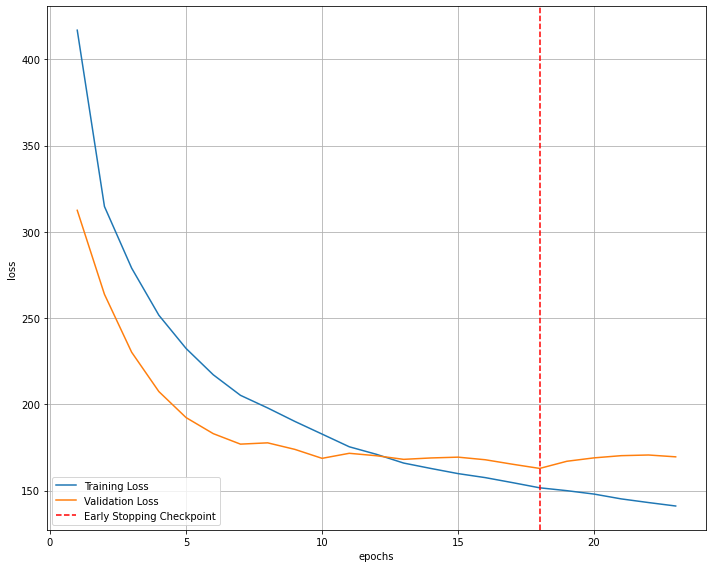

--------------- Fold: 10 ---------------------

              precision    recall  f1-score   support

           0       0.73      0.66      0.69       401
           1       0.95      0.83      0.89        76
           2       0.94      0.97      0.95        32
           3       0.78      0.97      0.87       134
           4       0.75      0.80      0.78       257
           5       0.90      0.87      0.88       149
           6       0.49      0.74      0.59       175
           7       0.00      0.00      0.00       113
           8       0.74      0.89      0.81       249
           9       0.70      0.80      0.75       251
          10       0.48      0.30      0.37        43
          11       0.80      0.62      0.70       106
          12       0.87      0.72      0.79       223
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00         8
          15       0.82      0.78      0.80       102
          16       0.90      0.56

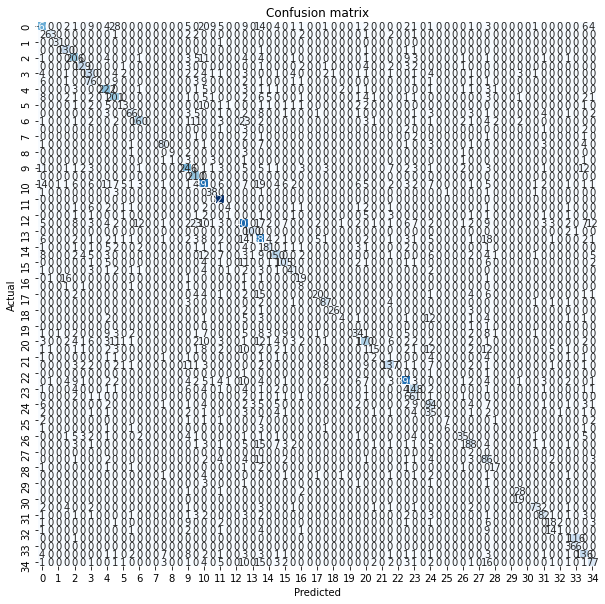

In [82]:
####### Setting up Cross-Validation #####
y=np.array(classes)
documents=np.array(documents)
kfold = StratifiedKFold(n_splits=nfold).split(documents, y)

####### Define Variables for Metrics #####
accuracys = []
scores= []
metriche = np.zeros((nfold,4,output_dim))

####### Cross-Validation Loop ############

for k, (train_ids, test_ids) in enumerate(kfold):
    
    padded_sentences_train,lenght_train = pad_text(documents[train_ids], seq_length = int(quant))
    padded_sentences_test,lenght_test = pad_text(documents[test_ids], seq_length = int(quant))
    
    encoded_sentences_train = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_train])
    encoded_sentences_test  = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_test])
    
    print("train:",encoded_sentences_train.shape,"len:",lenght_train.size, "train_y:",y[train_ids].size)
    print("test:",encoded_sentences_test.shape,"len:",lenght_test.size)
    
    
    
    train_loader, val_loader=create_data_loader(encoded_sentences_train,lenght_train,
                                                encoded_sentences_test,lenght_test,
                                                y[train_ids],y[test_ids],batch_size)
    

  ####### Instantiate model ############  
    model = ClassificationRNN(
                        pretrained_embedding=embeddings, 
                        output_dim=output_dim,
                        dropout=dropout_pc,
                        hidden_dim=hidden_dim,
                        num_layers=num_layers,
                        bidirectional=bidirectional
                        )
    
    model=model.double()

    loss_fn = nn.CrossEntropyLoss(reduction='sum').to(DEVICE)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=lr,weight_decay=0.01)
    model.to(DEVICE)
    model=train(model,optimizer,loss_fn,train_loader,val_loader,patience,n_epochs)
    
    ####### Compute Accuracy ##########
    y_pred=pytorch_predict(model,val_loader)
    
    y_true=y[test_ids]
    
    target_names=np.unique(y[train_ids])
    accuracys.append(metrics.accuracy_score(y_true, y_pred))

    ####### Compute Precision,Recall,F-Score ############
    score=precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, labels=target_names, average="weighted")
    scores.append(score[0:3])

    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    dizionario=metrics.classification_report(y_true, y_pred, target_names=target_names,output_dict=True)
    for k_d,(m_id, m_info) in enumerate(dizionario.items()):
        if k_d<output_dim:
            for j_d,key in enumerate(m_info):
                metriche[k,j_d,k_d]=m_info[key]
        else:
            break

     ## Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cbar=False,cmap=plt.cm.Blues)
    ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=target_names, 
           yticklabels=target_names, title="Confusion matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

arr = np.array(scores)


## Results Output

In [83]:
print("Overall results of the cross-validation procedure")
print()
print("Level 1")
print()

print('\nCV accuracy: %.2f +/- %.2f max: %.2f' % (np.mean(accuracys)*100, np.std(accuracys)*100,np.max(accuracys)*100))
print('\nCV precision: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,0])*100, np.std(arr[:,0])*100,np.max(arr[:,0])*100))
print('\nCV recall: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,1])*100, np.std(arr[:,1])*100,np.max(arr[:,1])*100))
print('\nCV f1: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,2])*100, np.std(arr[:,2])*100,np.max(arr[:,2])*100))

print()
print("Level 2")
print()
print(f"{'Class':^7} | {'precision':^9}{'':^6} | {'recall':^10}{'':^5} | {'f1-measure':^6}{'':^5} | {'support':^9}")
for i in range(output_dim):
    print(f"{i :^7} | {np.mean(metriche[:,0,i])*100:^5.2f}  +/-{np.std(metriche[:,0,i])*100:^6.2f} | {np.mean(metriche[:,1,i])*100:^5.2f} +/-{np.std(metriche[:,1,i])*100:^6.2f} | {np.mean(metriche[:,2,i])*100:^5.2f} +/-{np.std(metriche[:,2,i])*100:^6.2f} | {np.mean(metriche[:,3,i]):^9.2f}")

Overall results of the cross-validation procedure

Level 1


CV accuracy: 70.15 +/- 2.47 max: 73.14

CV precision: 68.37 +/- 2.35 max: 71.63

CV recall: 70.15 +/- 2.47 max: 73.14

CV f1: 68.29 +/- 2.42 max: 71.38

Level 2

 Class  | precision       |   recall        | f1-measure      |  support 
   0    | 74.45  +/- 3.05  | 75.85 +/- 5.94  | 75.03 +/- 3.79  |  401.80  
   1    | 85.08  +/- 6.84  | 88.03 +/- 5.01  | 86.33 +/- 4.30  |   76.00  
   2    | 94.75  +/- 5.47  | 79.08 +/-27.79  | 83.29 +/-22.58  |   32.20  
   3    | 80.45  +/- 4.02  | 75.50 +/-17.45  | 77.08 +/-10.58  |  134.50  
   4    | 73.18  +/- 6.31  | 77.26 +/- 2.93  | 74.92 +/- 2.93  |  256.80  
   5    | 86.15  +/- 4.75  | 91.09 +/- 3.14  | 88.47 +/- 3.00  |  149.20  
   6    | 41.86  +/- 4.27  | 68.77 +/- 5.56  | 51.95 +/- 4.49  |  175.40  
   7    | 0.00   +/- 0.00  | 0.00  +/- 0.00  | 0.00  +/- 0.00  |  113.00  
   8    | 74.99  +/- 7.66  | 75.32 +/- 6.49  | 74.69 +/- 3.86  |  249.20  
   9    | 75.16  +/- 3.67  |